In [3]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import json
import seaborn as sns
import pandas as pd

In [4]:
df = pd.read_csv('remove_null.csv')
# df = df.drop(['Name','Customer_ID', 'ID',"SSN"], axis=1)

In [5]:
def column_description(column_data,result,column,outlier):
    description = column_data.describe()
    description_dict = description.to_dict()
    # number of null values
    description_dict['null'] = str(column_data.isnull().sum())
    if outlier:
        result['column'][column]=out_liar(column_data,description_dict)
    else:
        result['column_string'][column]=description_dict
    
def out_liar(column_data,description_dict):
    Q1 = column_data.quantile(0.25)
    Q3 = column_data.quantile(0.75)
    IQR = Q3 - Q1
    lowerBand = Q1 - 1.5 * IQR
    upperBand = Q3 + 1.5 * IQR
    outlier_lower = column_data[(column_data < lowerBand)]
    outlier_upper = column_data[(column_data > upperBand)]
    description_dict["outlier"] = {
        "lower": len(outlier_lower),
        "upper": len(outlier_upper),
        "Q1": Q1,
        "Q3": Q3,
        "IQR": IQR,
        "total": len(outlier_lower) + len(outlier_upper),
    }
    
    return description_dict

In [6]:
def hypothesis_numirical(column_data, y,result,column,x):
    p_value = pearsonr(column_data, y)[1]
    if p_value > 0.05:
        if "remove_colmn" not in result:
            result["remove_colmn"] = {
                "column": [],
                "reason": "p_value > 0.05"
            }
        result["remove_colmn"]["column"].append(column)
        x = x.drop(column,axis=1)
    else:
        column_description(column_data,result,column,True)
    return x


def hypothesis_stirng(column_data, y,result,column,x):
    if "string_column" not in result:
        result["string_column"] = []
    contingency_table = pd.crosstab(column_data, y)
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    result["string_column"].append(column)
    if p_value > 0.05:
        if "remove_colmn" not in result:
            result["remove_colmn"] = {
                "column": [],
                "reason": "p_value > 0.05"
            }
        result["remove_colmn"]["column"].append(column)
        x = x.drop(column,axis=1)
    else:
        column_description(column_data,result,column,False)
    return x

In [7]:
def clean_data(x, y):
    get_all_columns = x.columns
    result = {"column":{}}
    for column in get_all_columns:
        try:
            column_data = x[column]
            if column_data.dtype == "object":
                hypothesis_stirng(column_data, y,result,column,x)
                continue
            hypothesis_numirical(column_data, y, result,column,x)
        except Exception as e:
            continue
    with open("result.json", "w") as f:
        json.dump(result, f)
    return result,x

In [8]:
def BoxPlotForOutliar(x,result):
    len_column = len(result['column'])
    divide_number = 3
    total_row = len_column // divide_number

    #every colum has whole fig but in same column has three fig show all in one figfig, axes = plt.subplots(number_of_columns, 1, figsize=(8, 6 * number_of_columns))
    fig, axes = plt.subplots(total_row, divide_number, figsize=(15, 20 ))
    ax_row = 0
    ax_col = 0
    for i in x.columns:
        if x[i].dtype == "object":
            continue
        if ax_col % 2 == 0:
            sns.boxplot(x[i], ax=axes[ax_row, ax_col])
        else:
            sns.boxplot(x[i], ax=axes[ax_row, ax_col], color="orange")
        # title
        axes[ax_row, ax_col].set_title(i)
        # add some style to the outliers
        axes[ax_row, ax_col].set(ylim=(x[i].min(), x[i].max()))
        
        # add horizontal grid to the plot
        axes[ax_row, ax_col].yaxis.grid(True)
        # add x-tick labels
        axes[ax_row, ax_col].set_xticklabels([])
        # use color blue for odd columns and color otnage for even columns for color plot not background color
        
            
            
        
        ax_col += 1
        if ax_col == divide_number:
            ax_row += 1
            ax_col = 0

    plt.show()

In [9]:
def custom_encoding(y):
    mapping = {"Standard":1,"Good":2,"Poor":0,"Bad":0,'NM':0,"No":1,"Yes":2}
    y = y.map(mapping)
    return y

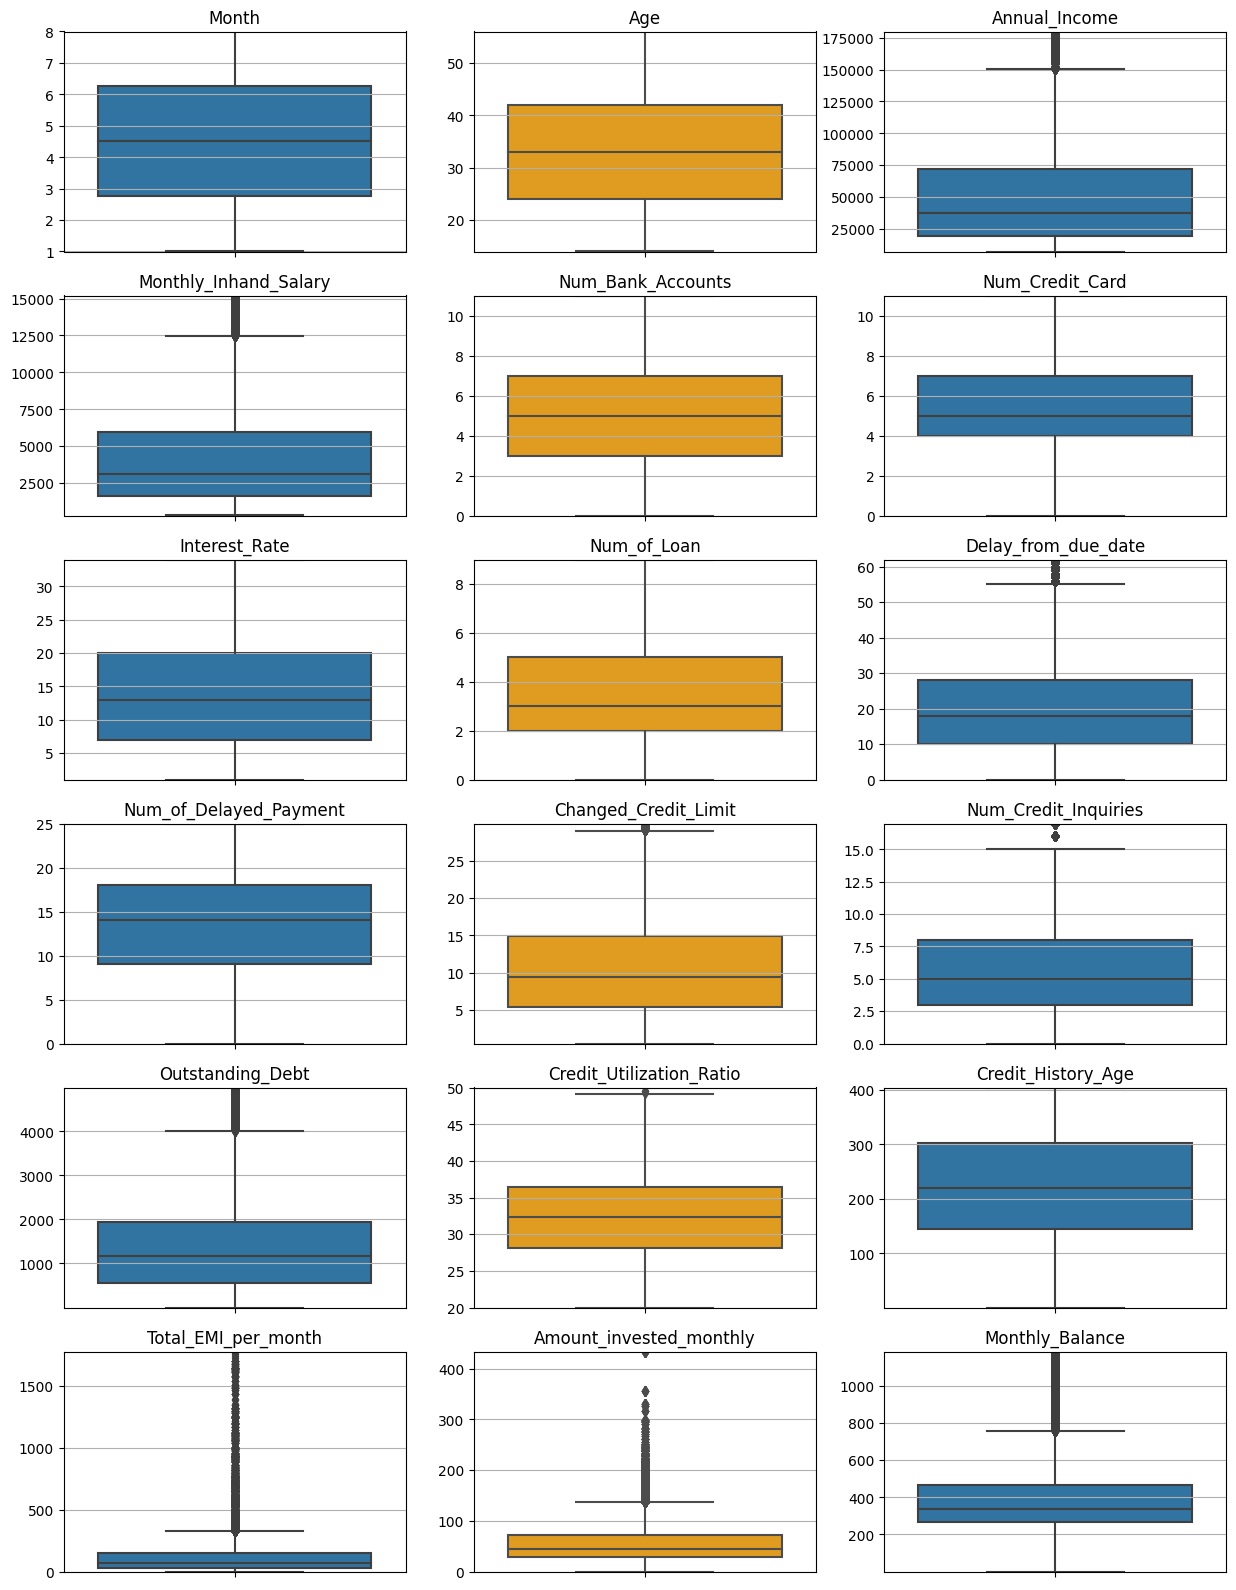

In [10]:
x = df.drop("Credit_Score", axis=1)
y = custom_encoding(df["Credit_Score"])
result,x= clean_data(x, y)
BoxPlotForOutliar(x,result)
new_df = pd.concat([x,y],axis=1)
new_df.to_csv("credit_score_clean.csv",index=False)